# Machine Learning

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("datasets/featured.csv")

In [3]:
df.transaction_date = pd.to_datetime(df.transaction_date)

In [4]:
df.dtypes

transaction_date                             datetime64[ns]
segment                                               int64
Total_Transaction                                     int64
thetas                                              float64
tes                                                 float64
                                                  ...      
sales_ewm_alpha_08699999999999999_lag_147           float64
sales_ewm_alpha_08899999999999999_lag_14            float64
sales_ewm_alpha_08899999999999999_lag_140           float64
sales_ewm_alpha_09299999999999998_lag_63            float64
sales_ewm_alpha_09699999999999999_lag_35            float64
Length: 62, dtype: object

In [5]:
df.head()

transaction_date  ...  sales_ewm_alpha_09699999999999999_lag_35
0       2018-07-09  ...                               1011.628725
1       2018-07-10  ...                                808.288862
2       2018-07-11  ...                                776.968666
3       2018-07-12  ...                                758.569060
4       2018-07-13  ...                                758.017072

[5 rows x 62 columns]

## Custom Function

In [6]:
import numpy as np

In [87]:
def smape(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [30]:
def lgbm_smape(predictions, data):
    labels = data.get_label()
    score = smape(labels, predictions)
    
    return "SMAPE", score, False

## Holdout

In [10]:
import warnings

warnings.filterwarnings("ignore")

In [11]:
train, val = \
    df.loc[(df["transaction_date"] < "2020-10-01"), :], df.loc[(df["transaction_date"] >= "2020-10-01"), :]

In [12]:
train.drop("transaction_date", axis=1, inplace=True)
val.drop("transaction_date", axis=1, inplace=True)

In [13]:
X_train, y_train = \
    train.drop("Total_Transaction", axis=1), train["Total_Transaction"]

In [14]:
X_train.shape, y_train.shape

((815, 60), (815,))

In [15]:
X_val, y_val = \
    val.drop("Total_Transaction", axis=1), val["Total_Transaction"]

In [16]:
X_val.shape, y_val.shape

((92, 60), (92,))

## LightGBM Model

In [17]:
import lightgbm as lgbm
import optuna

In [26]:
ml_train = lgbm.Dataset(data=X_train, label=y_train, feature_name=list(X_train.columns))

In [27]:
ml_val = lgbm.Dataset(data=X_val, label=y_val, feature_name=list(X_val.columns))

In [28]:
params = {'metric': {'mae'},
          'num_leaves': 10,
          'learning_rate': 0.02,
          'feature_fraction': 0.8,
          'max_depth': 5,
          'verbose': 0,
          'num_boost_round': 1000,
          'early_stopping_rounds': 200,
          'nthread': -1}

In [31]:
model = lgbm.train(params,
                   train_set=ml_train, 
                   valid_sets=[ml_train, ml_val],
                   num_boost_round=params['num_boost_round'],
                   early_stopping_rounds=params['early_stopping_rounds'],
                   feval=lgbm_smape)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's l1: 402.887	training's SMAPE: 33.747	valid_1's l1: 584.451	valid_1's SMAPE: 36.9023
Training until validation scores don't improve for 200 rounds
[2]	training's l1: 395.208	training's SMAPE: 33.1524	valid_1's l1: 572.28	valid_1's SMAPE: 35.9742
[3]	training's l1: 387.696	training's SMAPE: 32.5706	valid_1's l1: 560.374	valid_1's SMAPE: 35.0748
[4]	training's l1: 380.307	training's SMAPE: 31.9976	valid_1's l1: 548.776	valid_1's SMAPE: 34.2065
[5]	training's l1: 373.066	training's SMAPE: 31.4356	valid_1's l1: 537.392	valid_1's SMAPE: 33.3614
[6]	training's l1: 365.98	training's SMAPE: 30.8847	valid_1's l1: 526.195	valid_1's SMAPE: 32.5369
[7]	training's l1: 359.026	training's SMAPE: 30.3438	valid_1's l1: 515.263	valid_1's SMAPE: 31.7386
[8]	training's l1: 352.223	training's SMAPE: 29.814	valid_1's l1: 504.593	va

In [32]:
model.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('l1', 73.27730885674798),
                          ('SMAPE', 6.815176934734746)]),
             'valid_1': OrderedDict([('l1', 97.01098018357182),
                          ('SMAPE', 5.622700126971268)])})

In [39]:
model.params

{'metric': {'mae'},
 'num_leaves': 10,
 'learning_rate': 0.02,
 'feature_fraction': 0.8,
 'max_depth': 5,
 'verbose': 0,
 'nthread': -1,
 'num_iterations': 1000,
 'early_stopping_round': 200}

In [42]:
smape(y_val, model.predict(X_val, num_iteration=model.best_iteration))

5.622700126971268

### Hyperparameter Optimization

In [55]:
def objective(trial):
    num_leaves = trial.suggest_int('num_leaves', 2, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    feature_fraction = trial.suggest_uniform("feature_fraction", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 2, 25)
    num_iteration = trial.suggest_int("num_iterations", 100, 10000, step=100)
    early_stopping_round = trial.suggest_int("early_stopping_round", 1, 500, step=25)
    num_boost_round = trial.suggest_int('num_boost_round', 100, 10000, step=200)
    bagging_fraction  = trial.suggest_uniform('bagging_fraction', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    params = {
        'metric': {'mae'},
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'feature_fraction': feature_fraction,
        'max_depth': max_depth,
        'num_iterations': num_iteration,
        'early_stopping_rounds': early_stopping_round,
        'bagging_fraction': bagging_fraction,
        'colsample_bytree': colsample_bytree,
        'num_boost_round': num_boost_round,
    }
    
    model = lgbm.train(params,
                   train_set=ml_train, 
                   valid_sets=[ml_train, ml_val],
                   num_boost_round=params['num_boost_round'],
                   early_stopping_rounds=params['early_stopping_rounds'],
                   feval=lgbm_smape)
    
    preds = model.predict(X_val, num_iteration=model.best_iteration)
    score = smape(y_val, preds)
    
    return score

In [70]:
study = optuna.create_study(direction="minimize")

[I 2023-05-02 16:45:14,440] A new study created in memory with name: no-name-6ca15959-18b9-4559-b99f-7808ff9f276d


In [ ]:
study.optimize(objective, n_trials=500, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/500 [00:00<?, ?it/s]

[1]	training's l1: 406.336	training's SMAPE: 34.012	valid_1's l1: 590.743	valid_1's SMAPE: 37.383
Training until validation scores don't improve for 401 rounds
[2]	training's l1: 401.997	training's SMAPE: 33.6746	valid_1's l1: 584.699	valid_1's SMAPE: 36.9168
[1]	training's l1: 410.208	training's SMAPE: 34.3132	valid_1's l1: 596.041	valid_1's SMAPE: 37.7938
Training until validation scores don't improve for 326 rounds
[3]	training's l1: 398.129	training's SMAPE: 33.375	valid_1's l1: 579.158	valid_1's SMAPE: 36.492
[2]	training's l1: 409.69	training's SMAPE: 34.2732	valid_1's l1: 595.227	valid_1's SMAPE: 37.7309
[4]	training's l1: 393.93	training's SMAPE: 33.0485	valid_1's l1: 573.25	valid_1's SMAPE: 36.0401
[5]	training's l1: 390.007	training's SMAPE: 32.7443	valid_1's l1: 567.687	valid_1's SMAPE: 35.6173
[6]	training's l1: 385.855	training's SMAPE: 32.421	valid_1's l1: 561.897	valid_1's SMAPE: 35.1779
[3]	training's l1: 409.172	training's SMAPE: 34.2332	valid_1's l1: 594.414	valid_1's

### Final Model

In [73]:
params = study.best_params
params

{'num_leaves': 95,
 'learning_rate': 0.09500333655488247,
 'feature_fraction': 0.9480086767872363,
 'max_depth': 19,
 'num_iterations': 4100,
 'early_stopping_round': 126,
 'num_boost_round': 6300,
 'bagging_fraction': 0.14407079000521839,
 'colsample_bytree': 0.6949245462477955}

In [74]:
study.best_value

4.945714952171538

In [122]:
model = lgbm.train(params,
                   train_set=ml_train, 
                   valid_sets=[ml_train, ml_val],
                   num_boost_round=params['num_boost_round'],
                   early_stopping_rounds=params['early_stopping_round'],
                   feval=lgbm_smape)

[LightGBM] [Warning] feature_fraction is set=0.9480086767872363, colsample_bytree=0.6949245462477955 will be ignored. Current value: feature_fraction=0.9480086767872363
[LightGBM] [Warning] feature_fraction is set=0.9480086767872363, colsample_bytree=0.6949245462477955 will be ignored. Current value: feature_fraction=0.9480086767872363
[LightGBM] [Warning] feature_fraction is set=0.9480086767872363, colsample_bytree=0.6949245462477955 will be ignored. Current value: feature_fraction=0.9480086767872363
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14562
[LightGBM] [Info] Number of data points in the train set: 815, number of used features: 59
[LightGBM] [Info] Start training from score 1225.446626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 183038	training's SMAPE: 31.4455	valid_1's l2: 35748

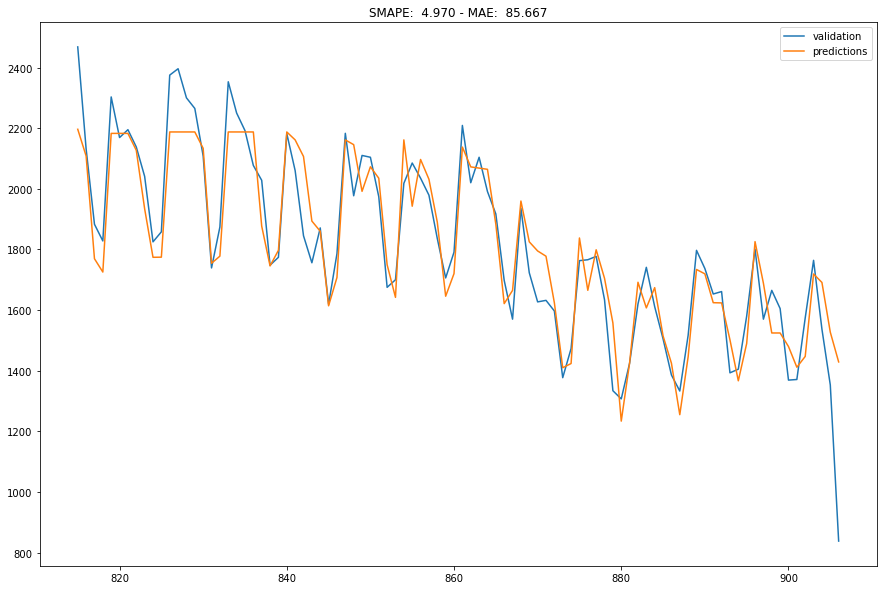

In [76]:
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

predictions = model.predict(X_val, num_iteration=model.best_iteration)
score_smape = smape(y_val, predictions)
score_mae = mean_absolute_error(y_val, predictions)

graph = pd.DataFrame()
graph["validation"] = y_val
graph["predictions"] = predictions

graph.plot(figsize=(15, 10))
plt.title(f"SMAPE: {score_smape: .3f} - MAE: {score_mae: .3f}")
plt.show()

### Feature Importances

In [124]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(15, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

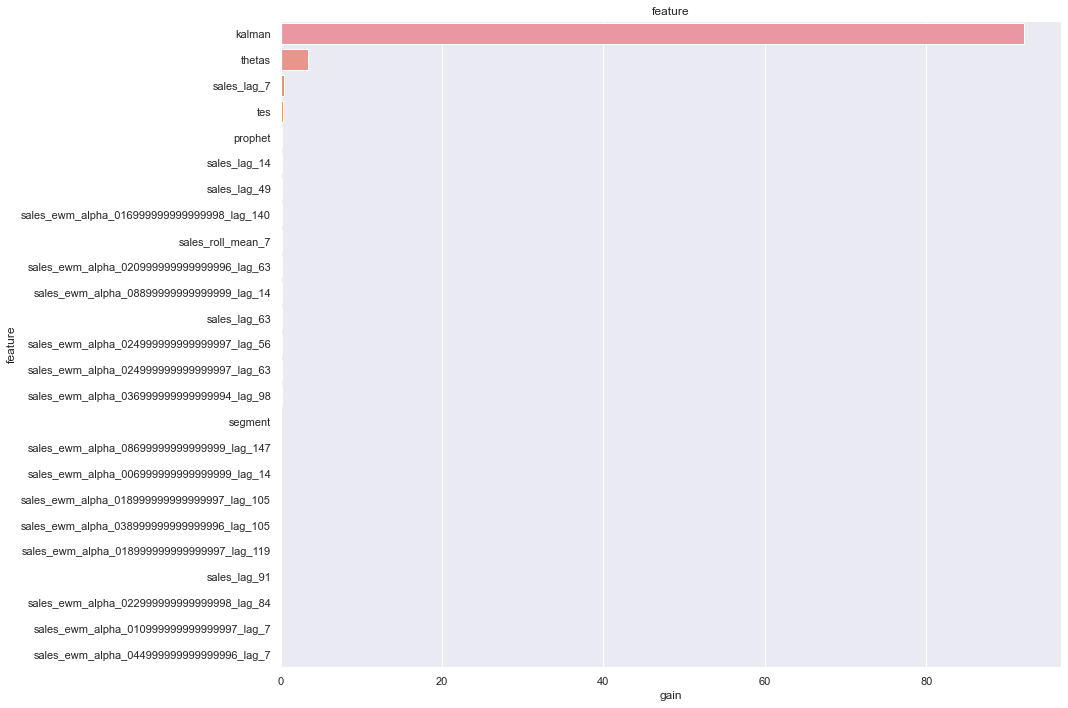

In [125]:
plot_lgb_importances(model, plot=True, num=20)

### Hyperparameter Importances

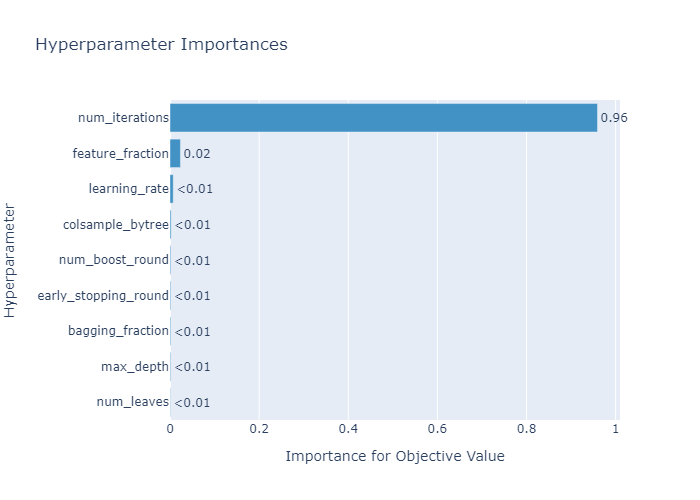

In [126]:
optuna.visualization.plot_param_importances(study).show(renderer="png")

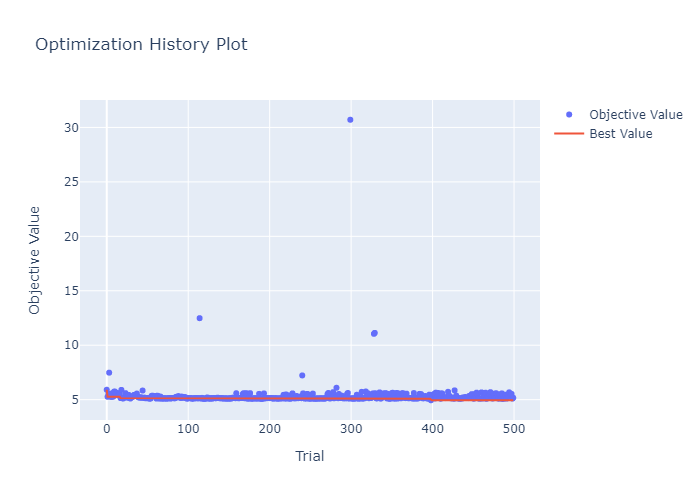

In [127]:
optuna.visualization.plot_optimization_history(study).show(renderer="png")

## Linear Model

In [81]:
from sklearn.linear_model import  LinearRegression

In [116]:
model = LinearRegression().fit(X_train, y_train)

predictions = model.predict(X_val)

mae_score = mean_absolute_error(y_val, predictions)
smape_score = smape(y_val, predictions)

In [117]:
smape_score, mae_score

(4.310362155800085, 73.18266577526397)

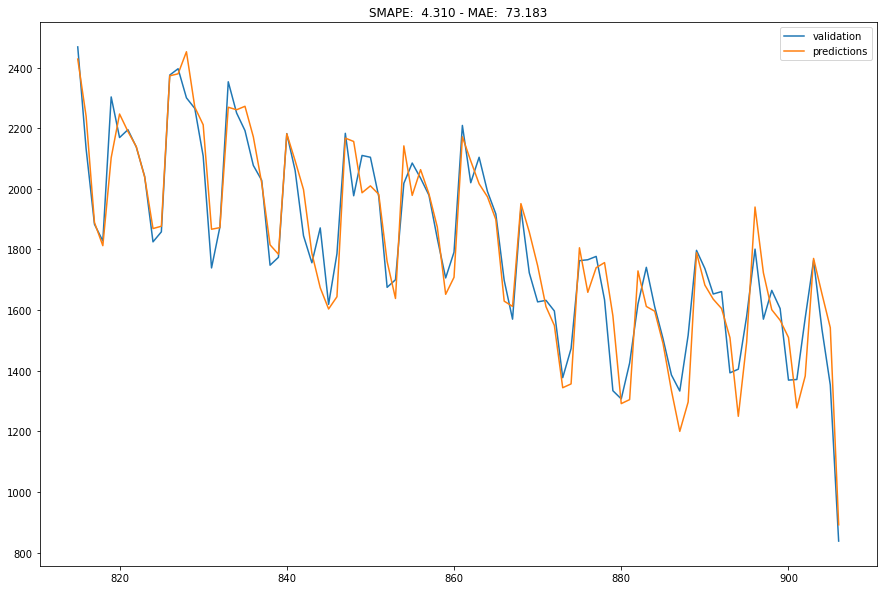

In [118]:
score_smape = smape(y_val, predictions)
score_mae = mean_absolute_error(y_val, predictions)

graph = pd.DataFrame()
graph["validation"] = y_val
graph["predictions"] = predictions

graph.plot(figsize=(15, 10))
plt.title(f"SMAPE: {score_smape: .3f} - MAE: {score_mae: .3f}")
plt.show()

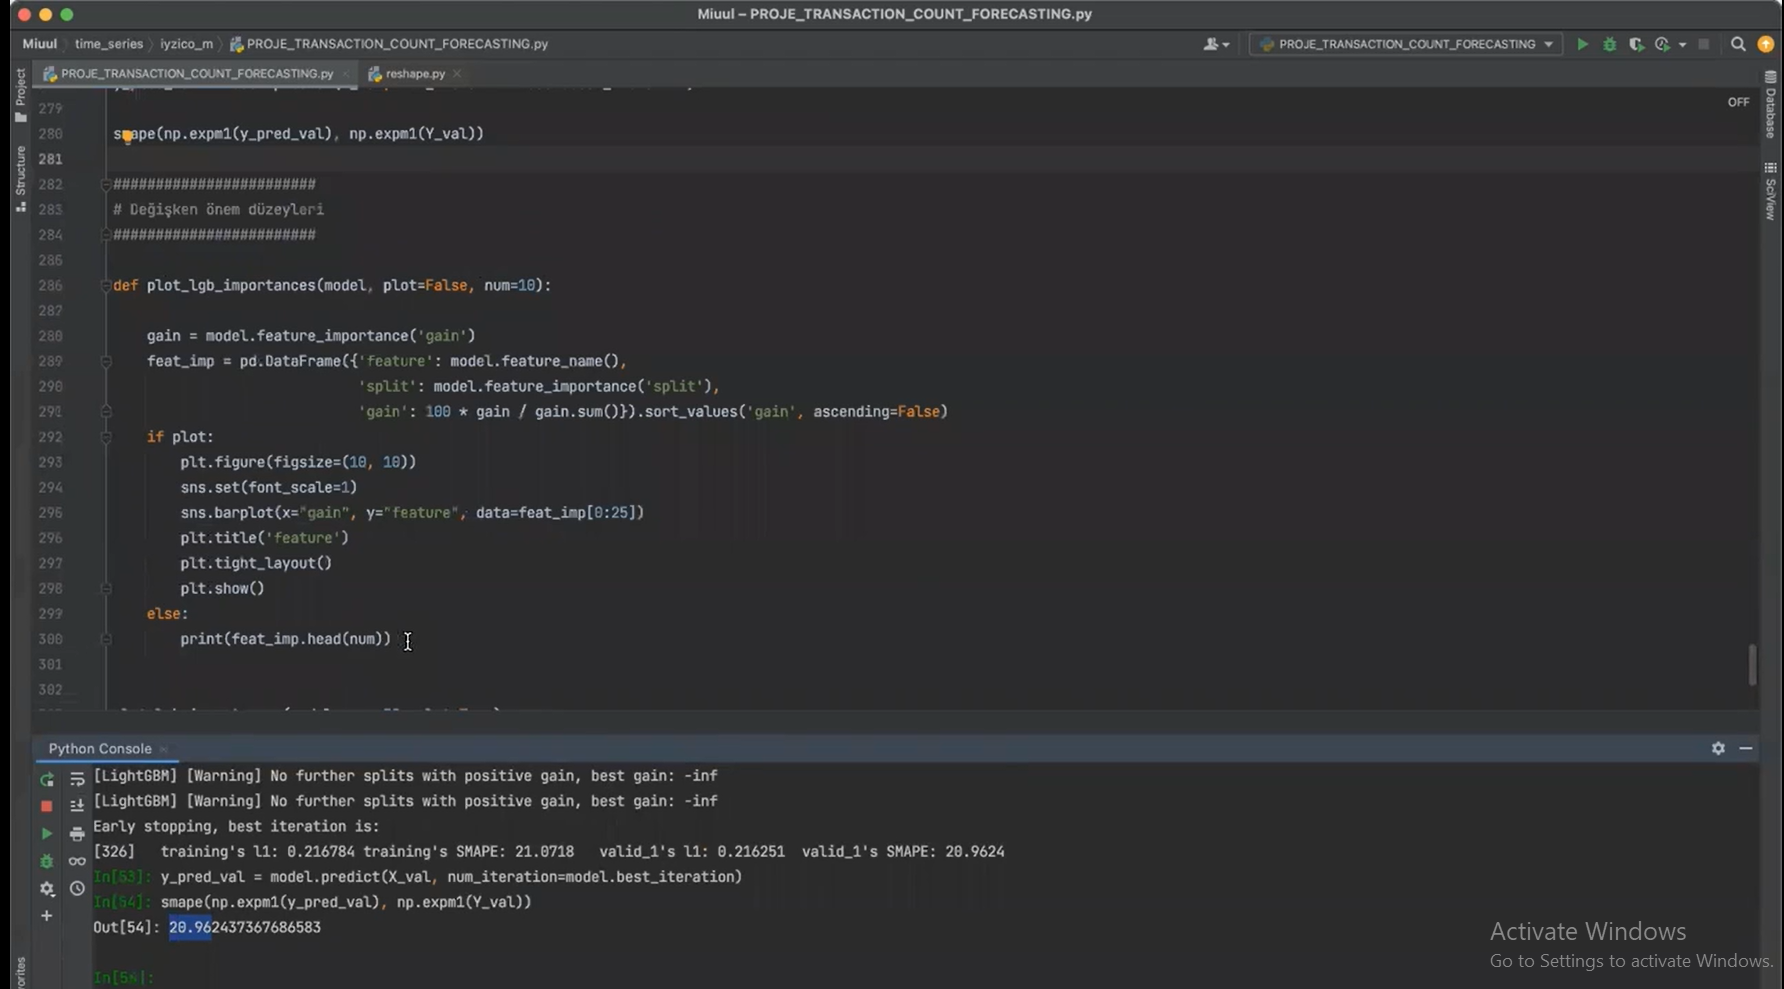